In [2]:
import logging
import os
import pickle

import bayesflow as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from cmdstanpy import CmdStanModel
from matplotlib import cm
from scipy import stats
from tqdm.autonotebook import tqdm

cmap = plt.get_cmap("viridis", 6)

/Users/marvin/miniforge3/envs/cmpe/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
class GMM(tfp.distributions.MixtureSameFamily):
    def __init__(self, theta):
        logging.getLogger().setLevel(logging.ERROR)
        mixture_weights_dist = tfp.distributions.Categorical(probs=[0.5, 0.5])
        components_dist = tfp.distributions.MultivariateNormalDiag(
            loc=tf.stack([theta, -1.0 * theta], axis=1), scale_diag=[[0.5, 0.5]]
        )

        super().__init__(mixture_distribution=mixture_weights_dist, components_distribution=components_dist)


class GMMPrior:
    def __init__(self, prior_location=[0, 0], prior_scale_diag=[1, 1]):
        self.dist = tfp.distributions.MultivariateNormalDiag(loc=prior_location, scale_diag=prior_scale_diag)

    def __call__(self, batch_size=None):
        theta = self.dist.sample([batch_size]) if batch_size else self.dist.sample()
        return theta


class GMMSimulator:
    def __init__(self, dist, n_obs=10):
        self.dist = dist
        self.n_obs = n_obs

    def __call__(self, theta, n_obs=None):
        if n_obs is None:
            n_obs = self.n_obs
        x = self.dist(theta).sample([n_obs])
        x = tf.transpose(x, perm=[1, 0, 2])
        return x

In [4]:
prior = GMMPrior(prior_location=[0, 0])
simulator = GMMSimulator(GMM)

generative_model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, prior_is_batched=True, simulator_is_batched=True
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
simulations = generative_model(2000)
theta = simulations["prior_draws"]
y = simulations["sim_data"]

In [6]:
print("theta shape:", theta.shape)
print("y shape:", y.shape)

theta shape: (2000, 2)
y shape: (2000, 10, 2)


In [ ]:
for i in range(5):
    plt.plot(y[i, :, 0], y[i, :, 1], "o")

    # plot theta^* and circle with +-1SD for reference
    plt.plot(theta[i, 0], theta[i, 1], "*", markersize=10, color="gray")
    plt.gca().add_patch(plt.Circle((theta[i, 0], theta[i, 1]), radius=1, color="gray", fill=False))

    # add another circle at the 2nd mode
    plt.gca().add_patch(
        plt.Circle((-theta[i, 0], -theta[i, 1]), radius=1, color="gray", linestyle="dotted", fill=False)
    )

    plt.axis("equal")
    plt.show()

In [ ]:
SIMULATION_BUDGET = 1024
filename = "gmm_train_data.pkl"


if os.path.exists(filename):
    with open(filename, "rb") as f:
        train_data = pickle.load(f)
    print("loaded train data from file")

else:
    logging.getLogger().setLevel(logging.ERROR)
    print("generating new train data and saving it")
    train_data = generative_model(SIMULATION_BUDGET)
    with open(filename, "wb") as f:
        pickle.dump(train_data, f)

num_params = train_data["prior_draws"].shape[1]

In [ ]:
NUM_TEST = 1000
filename = "gmm_test_data.pkl"


if os.path.exists(filename):
    with open(filename, "rb") as f:
        test_data = pickle.load(f)
    print("loaded test data from file")

else:
    logging.getLogger().setLevel(logging.ERROR)
    print("generating new test data and saving it")
    test_data = generative_model(NUM_TEST)
    with open(filename, "wb") as f:
        pickle.dump(test_data, f)

## Generate reference posterior on test data

In [34]:
test_data = generative_model(1)

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

num_posterior_samples = 5000
iter_warmup = 2000

y = test_data["sim_data"].numpy()
theta_true = test_data["prior_draws"]
n_sim, n_obs, data_dim = y.shape
_, param_dim = theta_true.shape

iter_sampling = num_posterior_samples // 2

posterior_samples = np.zeros((n_sim, num_posterior_samples, param_dim))
trace_plots = []

for i in tqdm(range(n_sim), desc="HMC running ..."):
    stan_data = {"n_obs": n_obs, "data_dim": data_dim, "x": y[i]}
    model = CmdStanModel(stan_file="gmm.stan")
    fit = model.sample(
        data=stan_data,
        iter_warmup=iter_warmup,
        iter_sampling=iter_sampling,
        chains=1,
        inits={"theta": theta_true[i].tolist()},
        show_progress=False
    )
    posterior_samples_chain = fit.stan_variable("theta")
    posterior_samples[i] = np.concatenate([posterior_samples_chain, -1.0 * posterior_samples_chain], axis=0)

HMC running ...: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


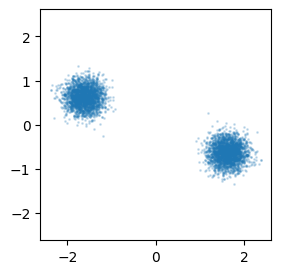

In [35]:
# visualize
f, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(box_aspect=1))
ax.scatter(posterior_samples[0, :, 0], posterior_samples[0, :, 1], alpha=0.2, s=1)
ax.set_aspect("equal")

In [ ]:
np.save("test.npy", posterior_samples.astype(np.float32))

## BayesFlow trainer

In [ ]:
trainer_npe = bf.trainers.Trainer(
    amortizer=bf.amortizers.AmortizedPosterior(
        inference_net=bf.networks.InvertibleNetwork(
            num_params=2, num_coupling_layers=4, coupling_design="spline", permutation="learnable"
        ),
        summary_net=bf.networks.DeepSet(summary_dim=2 * 2),
    ),
    generative_model=generative_model,
    default_lr=1e-3,
    memory=False,
    checkpoint_path=f"checkpoints/gmm_npe",
    max_to_keep=1,
)

In [ ]:
_ = trainer_npe.train_offline(train_data, epochs=30, batch_size=32)

# Evaluation

In [ ]:
# add your models here

trainers = (trainer_npe,)
names = ("NPE",)

## Evaluation on a single data set (pretty plots)

In [ ]:
theta = np.array([[-1.8, -1.0]])
x = simulator(theta)
test_sims = {"summary_conditions": x, "parameters": theta}

In [ ]:
# HMC
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

n_sim, n_obs, data_dim = x.shape
_, param_dim = theta.shape

stan_data = {"n_obs": n_obs, "data_dim": data_dim, "x": x[0].numpy()}
model = CmdStanModel(stan_file="gmm.stan")
fit = model.sample(data=stan_data, iter_warmup=2000, iter_sampling=5000, chains=1, show_progress=False)
posterior_samples_chain = fit.stan_variable("theta")
posterior_samples = np.concatenate([posterior_samples_chain, -1.0 * posterior_samples_chain], axis=0)

side = np.linspace(-3.0, 3.0, 200)
xx, yy = np.meshgrid(side, side)
obs_data_rep = np.concatenate([x] * 40000, axis=0)
params = np.c_[xx.flatten(), yy.flatten()]

f, axes = plt.subplots(1, 5, figsize=(10, 2))
hmc_kde = stats.gaussian_kde(posterior_samples.T, bw_method=0.05)
hmc_pdf = hmc_kde(np.vstack([xx.ravel(), yy.ravel()]))

axes[0].pcolormesh(xx, yy, hmc_pdf.reshape(xx.shape), cmap=cm.viridis, rasterized=True)
axes[0].scatter(theta[:, 0], theta[:, 1], color="magenta", s=50, marker="*")
axes[0].set_aspect("equal")
axes[0].set_title("True", fontsize=24)
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)

for i, (trainer, name) in enumerate(zip(trainers, names), 1):
    # Compute log density on relevant posterior range
    lpdf = trainer.amortizer.log_posterior({"parameters": params, "summary_conditions": obs_data_rep})

    # Plot the density map using nearest-neighbor interpolation
    axes[i].pcolormesh(xx, yy, np.exp(lpdf).reshape(200, 200), cmap=cm.viridis, rasterized=True)
    axes[i].scatter(theta[:, 0], theta[:, 1], color="magenta", s=50, marker="*")
    axes[i].set_title(name, fontsize=24)
    axes[i].set_aspect("equal")
    axes[i].set_xlim(-3, 3)
    axes[i].set_ylim(-3, 3)

plt.savefig("gmm_density.pdf", bbox_inches="tight")

f, axes = plt.subplots(1, 5, figsize=(10, 2))

axes[0].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, color=cmap(4), s=1, rasterized=True)
axes[0].scatter(theta[:, 0], theta[:, 1], color="magenta", s=150, marker="*")
axes[0].set_aspect("equal")
axes[0].set_title("True", fontsize=24)
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)

for i, (trainer, name) in enumerate(zip(trainers, names), 1):
    samples = trainer.amortizer.sample(test_sims, n_samples=2000)

    # Compute log density on relevant posterior range
    # axes[i].scatter(posterior_samples[:, 0], posterior_samples[:, 1], alpha=0.1, color=cmap(i-1), s=1, rasterized=True)
    axes[i].scatter(samples[:, 0], samples[:, 1], alpha=0.5, color=cmap(i - 1), s=1, label=name, rasterized=True)

    # Plot the density map using nearest-neighbor interpolation
    axes[i].scatter(theta[:, 0], theta[:, 1], color="magenta", s=150, marker="*")
    axes[i].set_title(name, fontsize=24)
    axes[i].set_aspect("equal")
    axes[i].set_xlim(-3, 3)
    axes[i].set_ylim(-3, 3)

plt.savefig("gmm_samples.pdf", bbox_inches="tight")

## Evaluation across the prior space

In [ ]:
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
def sample_hmc(test_sims, iter_warmup=2000, iter_sampling=2000, **kwargs):
    x = test_sims["summary_conditions"]
    theta_true = test_sims["parameters"]
    n_sim, n_obs, data_dim = x.shape
    _, param_dim = theta_true.shape

    num_posterior_samples = iter_sampling * 2

    posterior_samples = np.zeros((n_sim, num_posterior_samples, param_dim))
    trace_plots = []

    for i in tqdm(range(n_sim), desc="HMC running ..."):
        stan_data = {"n_obs": n_obs, "data_dim": data_dim, "x": x[i]}
        model = CmdStanModel(stan_file="gmm.stan")
        fit = model.sample(
            data=stan_data,
            iter_warmup=iter_warmup,
            iter_sampling=iter_sampling,
            chains=1,
            show_progress=False,
            **kwargs,
        )
        posterior_samples_chain = fit.stan_variable("theta")
        posterior_samples[i] = np.concatenate([posterior_samples_chain, -1.0 * posterior_samples_chain], axis=0)
        dat = az.InferenceData(posterior=fit.draws_xr())

        trace_plot = az.plot_trace(dat, var_names="theta", compact=False, show=False)
        trace_plots.extend(trace_plot)
        plt.close()

    return posterior_samples, trace_plots

In [ ]:
NUM_TEST = 10

In [ ]:
test_sims = trainer_npe.configurator(generative_model(NUM_TEST))
y = test_sims["summary_conditions"]
theta_true = test_sims["parameters"]

In [ ]:
hmc_posterior_samples, traces = sample_hmc(test_sims)

In [ ]:
npe_posterior_samples = trainer_npe.amortizer.sample(test_sims, n_samples=4000)